## Analysis of RECS data and derive regression models (XGBoost)

DATA Preparation
 - Call generateX from generateXdata.py file to prepare the X data
 - y data is extracted from the raw file

Running data Models
1. Split train and test data (75:25 ratio)
2. Run XGBOOST algo against train data
3. Use Test to validate prediction
4. Plot the residual and accuracy if possible


In [1]:
# IMport dependencies
import pandas as pd
from pandas import set_option
import numpy as np
import os
import csv

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# import required libraries related to xgBoost and sci-kit learn
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# import gridsearch cv for multiple iterations
from sklearn.model_selection import GridSearchCV

# explain xgboost preiction and model
import shap

# from keras.utils import to_categorical

# import preprocessing from sklearn
from sklearn import preprocessing

# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

# import generateXdata.py to prepare the data
from generateXdata import generateX


In [2]:
# gobal variables
dataFilePath = "dataforfinalproject"
filename = "RECS_COMBINED_DATA.csv"
cols_file = "Final_Columns_withCat.csv"




### Prepare Data

In [3]:
# obtain features contributing to the Y = BTU or DOllar
X, vocab = generateX(ohe = True, target = "DOLLAR")

 X Features shape : (22591, 87)
cols with values as 99 and -2: ['CELLAR', 'STORIES', 'PRKGPLC1', 'BEDROOMS', 'FUELPOOL', 'SIZRFRI1', 'TYPERFR1', 'AGERFRI1', 'SIZRFRI2', 'TYPERFR2', 'AGERFRI2', 'NUMFREEZ', 'SIZFREEZ', 'AGEFRZR', 'STOVENFUEL', 'OVENUSE', 'AMTMICRO', 'DWASHUSE', 'WASHLOAD', 'WASHTEMP', 'EQUIPM', 'FUELHEAT', 'EQUIPAGE', 'PROTHERM', 'TEMPHOME', 'TEMPGONE', 'TEMPNITE', 'AGECENAC', 'USECENAC', 'NUMBERAC', 'WWACAGE', 'USEWWAC', 'FUELH2O', 'WHEATAGE', 'WHEATSIZ', 'LGTOUTNUM', 'ESDISHW', 'PGASHEAT', 'WOODAMT'] 

Duplicate Count : 0
shape of X is (22591, 86)


In [4]:
X

array([[  2.,   3.,   3., ...,   0.,   3.,   9.],
       [  2.,   1.,   3., ...,   0.,   3.,   7.],
       [  2.,   3.,   3., ...,   0.,   3.,   4.],
       ..., 
       [  3.,   3.,   1., ...,   0.,   1.,   7.],
       [  1.,  41.,   3., ...,   0.,   3.,   7.],
       [  2.,   3.,   3., ...,   0.,   3.,   4.]])

In [5]:
vocab[:20]

['ADQINSUL',
 'AGECENAC',
 'AGEFRZR',
 'AGERFRI1',
 'AGERFRI2',
 'AMTMICRO',
 'BEDROOMS',
 'BTUEL',
 'BTUELCOL',
 'BTUELOTH',
 'BTUELRFG',
 'BTUELSPH',
 'BTUELWTH',
 'BTUFO',
 'CDD65',
 'CELLAR',
 'CUFEETNG',
 'DIVISION',
 'DOLELCOL',
 'DOLELOTH']

In [6]:
# y = pd.read_csv(os.path.join(dataFilePath,filename), low_memory = False)['TOTALBTU']
y = pd.read_csv(os.path.join(dataFilePath,filename), low_memory = False)['TOTALDOLLAR']
y.shape

(22591,)

# XGBOOST - Predicting Total Consumption in BTU

In [7]:
#convert the dataset into an optimized data structure called Dmatrix 
#that XGBoost supports and gives it acclaimed performance and efficiency gains. 
data_dmatrix = xgb.DMatrix(data=X,label=y)

### Build base XGBoost model using K-Folds method

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(18072, 86)

In [46]:
def xgBoost_model(X_train, y_train, X_test, y_test, seed = 42):
    # Create the tuned model with configuration
    xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.6, learning_rate = 0.2,min_child_weight=5,
                max_depth = 7, alpha = 10, n_estimators = 220, subsample = 0.6, silent = 1)
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xg_reg.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, verbose=False)


    # MODEL REPORT

    preds_train = xg_reg.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, preds_train))
    train_accur = xg_reg.score(X_train, y_train)

    preds = xg_reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    accur = xg_reg.score(X_test, y_test)


    print("XG Boost MODEL REPORT \n")
    print("---------------------------------------------------------------------------------------------\n")
    print("Train RMSE: %f" % (train_rmse))
    print("Test RMSE: %f" % (rmse))
    print('The accuracy of the xgboost regressor is {:.2f} out of 1 on the training data'.format(train_accur))
    print('The accuracy of the xgboost regressor is {:.2f} out of 1 on the test data'.format(accur))
    
    prediction_allY = xg_reg.predict(X)
    print(prediction_allY.shape[0])
    overall_rmse = np.sqrt(mean_squared_error(y, prediction_allY))
    print("RMSE: %f" % (overall_rmse))

    print('The accuracy of the xgboost regressor is {:.2f} out of 1 on the all data'.format(xg_reg.score(X, y)))
    
    # retrieve performance metrics and plot it
    results = xg_reg.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)

    # plot regression error
    fig, axs = plt.subplots(figsize = (10,8))
    sns.lineplot(x_axis, results['validation_0']['rmse'], label='Train', ax = axs)
    sns.lineplot(x_axis, results['validation_1']['rmse'], label='Test', ax = axs)
    plt.legend()
    plt.ylabel('Regression Error')
    plt.title('XGBoost Regression Error')

    plt.show()
    
        
    return (pd.DataFrame(preds, columns = ['xgBoost_Predicted']),rmse, accur)

XG Boost MODEL REPORT 

---------------------------------------------------------------------------------------------

Train RMSE: 63.047354
Test RMSE: 296.810480
The accuracy of the xgboost regressor is 1.00 out of 1 on the training data
The accuracy of the xgboost regressor is 0.93 out of 1 on the test data
22591
RMSE: 144.229838
The accuracy of the xgboost regressor is 0.98 out of 1 on the all data


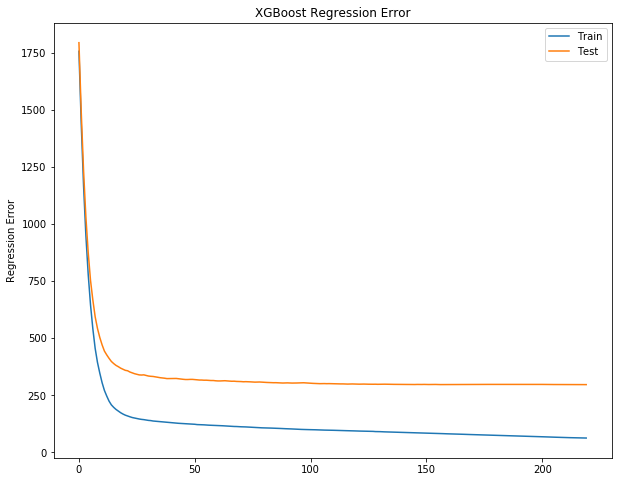

(      xgBoost_Predicted
 0           1296.348511
 1           2715.314697
 2           5367.677734
 3           1236.128540
 4           2326.986084
 5            640.143372
 6            267.624695
 7           1433.935059
 8           2297.290527
 9           1786.567383
 10          1148.514282
 11           822.027954
 12          1374.182617
 13           586.084656
 14          1787.352783
 15          1703.356079
 16          3927.338135
 17          2093.863281
 18          2282.392334
 19           420.868805
 20           329.774475
 21          1070.018555
 22          1382.539062
 23          4069.230957
 24          3100.509521
 25          1033.820435
 26          2298.991699
 27          2186.288086
 28          1693.367432
 29          2691.281494
 ...                 ...
 4489        3114.137451
 4490         695.926270
 4491         818.962036
 4492        1691.666382
 4493        1289.939209
 4494        2112.980957
 4495        1456.312256
 4496        1142.535767


In [47]:
xgBoost_model(X_train, y_train, X_test, y_test, 123)

In [15]:
# BASE MODEL
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.8, learning_rate = 0.1,min_child_weight=1,
                max_depth = 3, alpha = 10, n_estimators = 120, subsample = 0.8, silent = 1, seed = 123)

In [16]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xg_reg.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, verbose=False)


# MODEL REPORT

preds_train = xg_reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, preds_train))


preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))


print("MODEL REPORT \n")
print("---------------------------------------------------------------------------------------------\n")
print("Train RMSE: %f" % (train_rmse))
print("Test RMSE: %f" % (rmse))
print('The accuracy of the xgboost regressor is {:.2f} out of 1 on the training data'.format(xg_reg.score(X_train, y_train)))
print('The accuracy of the xgboost regressor is {:.2f} out of 1 on the test data'.format(xg_reg.score(X_test, y_test)))

MODEL REPORT 

---------------------------------------------------------------------------------------------

Train RMSE: 168.925839
Test RMSE: 184.696206
The accuracy of the xgboost regressor is 0.98 out of 1 on the training data
The accuracy of the xgboost regressor is 0.97 out of 1 on the test data


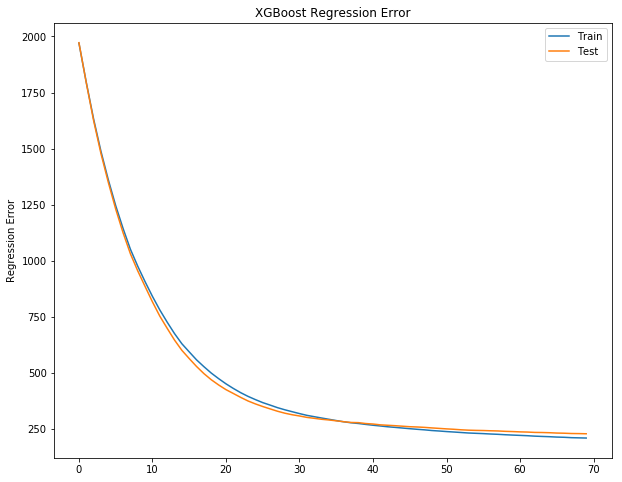

In [44]:
# retrieve performance metrics and plot it
results = xg_reg.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# plot regression error
fig, axs = plt.subplots(figsize = (10,8))
sns.lineplot(x_axis, results['validation_0']['rmse'], label='Train', ax = axs)
sns.lineplot(x_axis, results['validation_1']['rmse'], label='Test', ax = axs)
plt.legend()
plt.ylabel('Regression Error')
plt.title('XGBoost Regression Error')

plt.show()

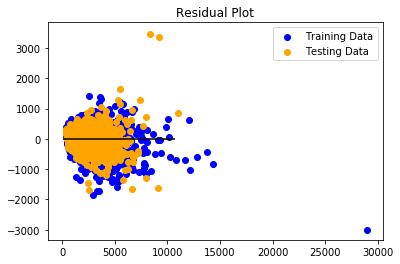

In [46]:
# RESIDUAL PLOT
plt.scatter(xg_reg.predict(X_train), xg_reg.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(xg_reg.predict(X_test), xg_reg.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

## START FINE-TUNING

FineTune #1 : Tune max_depth and min_child_weight


In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

# gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
#  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
#  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
#  param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1 = GridSearchCV(estimator = xg_reg, 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

## Run the regression model on all data and plot the Y estimated and Y actual

In [82]:
prediction_allY = xg_reg.predict(X)
print(prediction_allY.shape[0])
overall_rmse = np.sqrt(mean_squared_error(y, prediction_allY))
print("RMSE: %f" % (overall_rmse))

print('The accuracy of the xgboost regressor is {:.2f} out of 1 on the all data'.format(xg_reg.score(X, y)))

22591
RMSE: 158.021402
The accuracy of the xgboost regressor is 0.98 out of 1 on the all data


In [120]:
df_preds = pd.DataFrame(list(zip(list(prediction_allY),list(y))), columns = ["Predicted Price","Actual Price"])
# df_preds['Actual Price'] = y_test
df_preds.shape

(22591, 2)

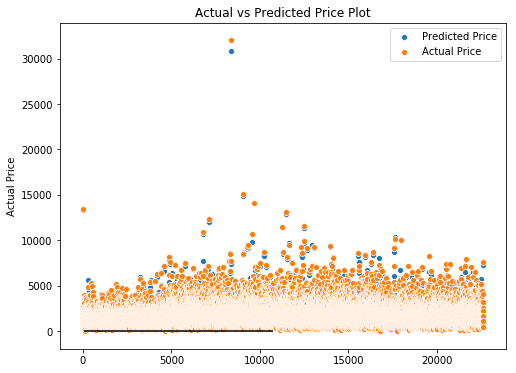

In [125]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.scatterplot(x = df_preds.index, y = "Predicted Price", data = df_preds, markers = "s", label = "Predicted Price")
sns.scatterplot(x = df_preds.index, y = "Actual Price", data = df_preds, markers = "X", label = "Actual Price")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Actual vs Predicted Price Plot")
plt.show()

# Using Shap explain the model

In [15]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X)

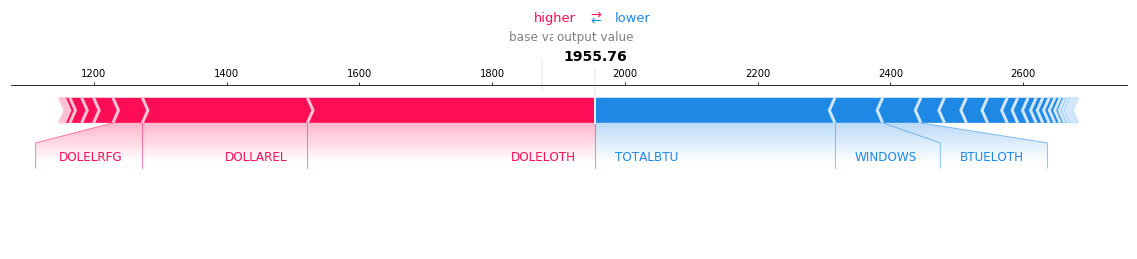

In [19]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[10,:], feature_names = vocab, matplotlib = True)

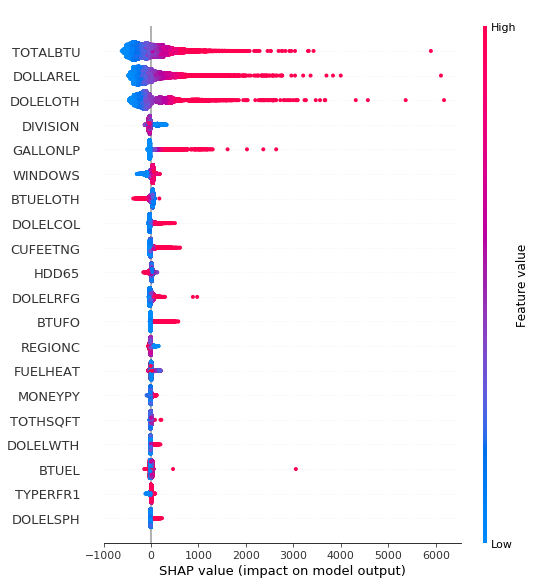

In [20]:
shap.summary_plot(shap_values, X, feature_names = vocab)

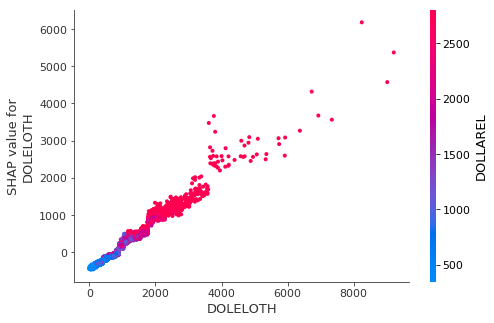

In [21]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("DOLELOTH", shap_values, X, feature_names = vocab)

In [ ]:
shap.image_plot(shap_values, X)


### k-fold Cross Validation using XGBoost
In order to build more robust models, it is common to do a k-fold cross validation where all the entries in the original training dataset are used for both training as well as validation. Also, each entry is used for validation just once. XGBoost supports k-fold cross validation via the cv() method.

In [21]:
params = {"objective":"reg:linear",'colsample_bytree': 0.7,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=500,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123,
                    verbose_eval = False)

In [22]:
print((cv_results["test-rmse-mean"]).tail(1))
cv_results.head()



499    193.940421
Name: test-rmse-mean, dtype: float64


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1960.968726,11.945971,1961.910425,49.630355
1,1775.679785,11.651927,1778.170483,48.489277
2,1610.132910,10.981522,1613.985694,47.788973
3,1461.236767,10.386246,1466.698315,47.950497
4,1326.756152,8.991017,1333.656201,48.737901


### Visualise the results

In [22]:
feat_imp_df  = pd.DataFrame(list(zip(vocab, xg_reg.feature_importances_)), columns = ['Feature','Importance'])
feat_imp_df.sort_values(['Importance'], ascending = False, inplace = True)
feat_imp_df.head()

,Feature,Importance
19,DOLELOTH,0.451363
68,TOTALBTU,0.084932
23,DOLLAREL,0.081883
32,FUELHEAT,0.027669
10,BTUELRFG,0.027411


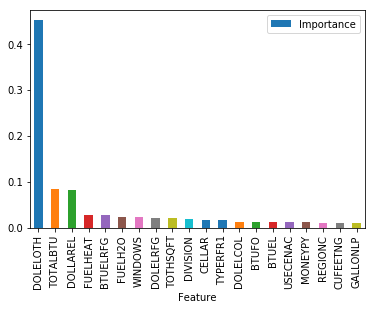

In [23]:
feat_imp_df[:20].plot(x = "Feature", y = "Importance", kind = "bar")

In [24]:
xg_reg1 = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

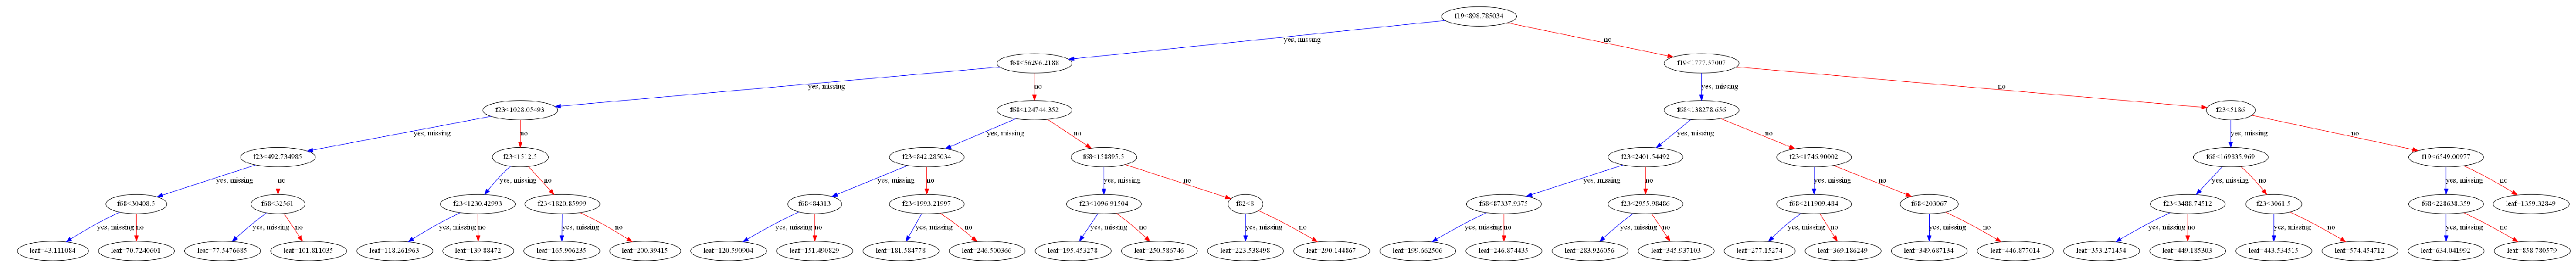

In [30]:
xgb.plot_tree(xg_reg1,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 50]
plt.savefig(os.path.join("output","xgboost_decisiontree.png"))
plt.show()


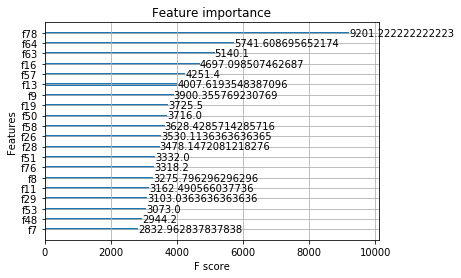

In [28]:
xgb.plot_importance(xg_reg,max_num_features = 20, importance_type = "cover")
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

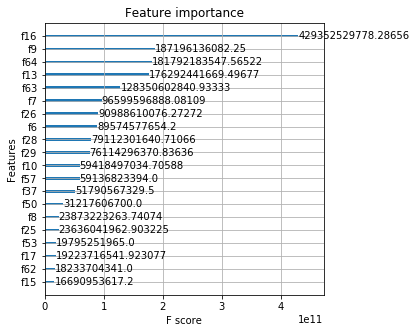

In [30]:
xgb.plot_importance(xg_reg,max_num_features = 20, importance_type = "gain")
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

### Using Eval Metric and looking at the learning curve

In [34]:
xg_reg_2 = xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.6, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 70)

In [54]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xg_reg_2.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:1960.23	validation_1-rmse:1963.19
[1]	validation_0-rmse:1775.18	validation_1-rmse:1774.75
[2]	validation_0-rmse:1610.44	validation_1-rmse:1609.5
[3]	validation_0-rmse:1462.15	validation_1-rmse:1460.59
[4]	validation_0-rmse:1326.4	validation_1-rmse:1322.76
[5]	validation_0-rmse:1207.57	validation_1-rmse:1202.02
[6]	validation_0-rmse:1102.74	validation_1-rmse:1096.12
[7]	validation_0-rmse:1003.06	validation_1-rmse:995.363
[8]	validation_0-rmse:918.703	validation_1-rmse:910.459
[9]	validation_0-rmse:837.69	validation_1-rmse:828.809
[10]	validation_0-rmse:765.145	validation_1-rmse:755.952
[11]	validation_0-rmse:704.972	validation_1-rmse:695.08
[12]	validation_0-rmse:648.652	validation_1-rmse:638.699
[13]	validation_0-rmse:603.142	validation_1-rmse:594.041
[14]	validation_0-rmse:556.717	validation_1-rmse:548.414
[15]	validation_0-rmse:518.329	validation_1-rmse:510.498
[16]	validation_0-rmse:481.209	validation_1-rmse:473.673
[17]	validation_0-rmse:446.673	validation_1-r

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=70, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [45]:
# make predictions for test data
y_pred = xg_reg_2.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
print(f"accuracy % is : {round(xg_reg_2.score(X_test, y_test)*100, 2)}")

RMSE: 186.832638
accuracy % is : 96.82


In [37]:
results = xg_reg_2.evals_result()
print(results)

{'validation_0': {'error': [-1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.

In [47]:
# retrieve performance metrics
results = xg_reg_2.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

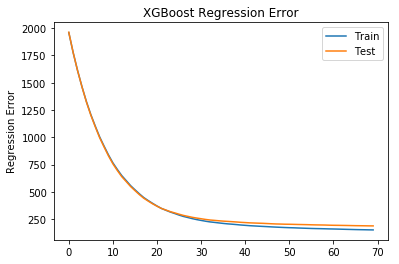

In [53]:
# plot regression error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('Regression Error')
plt.title('XGBoost Regression Error')
plt.show()